In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import model_to_dot
from PIL import Image
from keras.applications import ResNet152V2
from keras.models import Sequential
from keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
! unzip "/content/gdrive/MyDrive/25K.zip" #
#! unzip "/content/gdrive/MyDrive/50K.zip" #

Streaming output truncated to the last 5000 lines.
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3940.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3949.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3954.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3957.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3964.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_397.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3970.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3975.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinom

In [ ]:
path = "/content/NSCLC_Radiomics_50k_splitted2" #25K
#path = "/content/NSCLC_Radiomics_50k_TTV" #50K + cost sensitive

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    f"{path}/train",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

test_ds = keras.utils.image_dataset_from_directory(
    f"{path}/test",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

val_ds = keras.utils.image_dataset_from_directory(
    f"{path}/validation",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

Found 10000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


In [ ]:
# Define the new image size
new_image_size = (80, 80)

# Function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, new_image_size)
    return image, label

# Apply resizing to the datasets
train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)
val_ds = val_ds.map(resize_image)

In [ ]:
# Normalize the pixel values
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = image / 255.0  # Normalize pixel values
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

# One-hot encode the labels
num_classes = 5  # Update with the actual number of classes
train_ds = train_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
test_ds = test_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
val_ds = val_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))

# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.3, # 0.3,0.5,0.7
        temperature=30, #7,15,22,30
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
num_classes = 5
num_positions = 144  # Example for 18x18 image patches
input_shape = (80, 80, 3)
learning_rate = 0.001
weight_decay = 0.0001  # Increase weight decay if overfitting occurs
batch_size = 64
num_epochs = 100
image_size = 80
patch_size = 12
# Increase model complexity
transformer_layers = 1  # Increase the number of Transformer layers
projection_dim = 256    # Increase projection dimension(256)
num_heads = 4
num_patches = (image_size // patch_size) ** 2
transformer_units = [projection_dim , projection_dim]
mlp_head_units = [256, 128, 64]  # Increase MLP size[256, 128, 64]
          # Increase the number of attention heads

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dropout(0.1)(x3)  # Adjust dropout rate
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # MLP head
    mlp = layers.Dense(256, activation="relu")(representation)  # You can modify the size of the MLP
    mlp = layers.Dropout(0.5)(mlp)
    mlp = layers.Dense(128, activation="relu")(mlp)  # Add more dense layers as needed

    # Classify outputs.
    logits = layers.Dense(num_classes, activation="softmax")(mlp)  # Output layer for classification

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
vit = create_vit_classifier();
vit.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 patches (Patches)           (None, None, 432)            0         ['input_1[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 36, 256)              120064    ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 layer_normalization (Layer  (None, 36, 256)              512       ['patch_encoder[0][0]']   

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the model
vit.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
vit_train_losses = []
vit_val_losses = []
vit_train_accuracies = []
vit_val_accuracies = []
vit_train_precisions = []
vit_val_precisions = []
vit_train_recalls = []
vit_val_recalls = []
vit_train_cosine_similarity = []
vit_val_cosine_similarity = []

for epoch in range(100):
    # Train the model for one epoch
    #history = vit.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    history = vit.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    vit_train_losses.append(history.history['loss'][0])
    vit_val_losses.append(history.history['val_loss'][0])
    vit_train_accuracies.append(history.history['categorical_accuracy'][0])
    vit_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    vit_train_precisions.append(history.history['precision'][0])
    vit_val_precisions.append(history.history['val_precision'][0])
    vit_train_recalls.append(history.history['recall'][0])
    vit_val_recalls.append(history.history['val_recall'][0])
    vit_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    vit_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_loss'][0]
        best_weights = vit.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
vit.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.

100/100 [==============================] - 5s 49ms/step - loss: 0.1724 - categorical_accuracy: 0.9413 - top_5_categorical_accuracy: 1.0000 - precision: 0.9524 - recall: 0.9286 - cosine_similarity: 0.9493 - val_loss: 0.2072 - val_categorical_accuracy: 0.9336 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.9494 - val_recall: 0.9225 - val_cosine_similarity: 0.9449


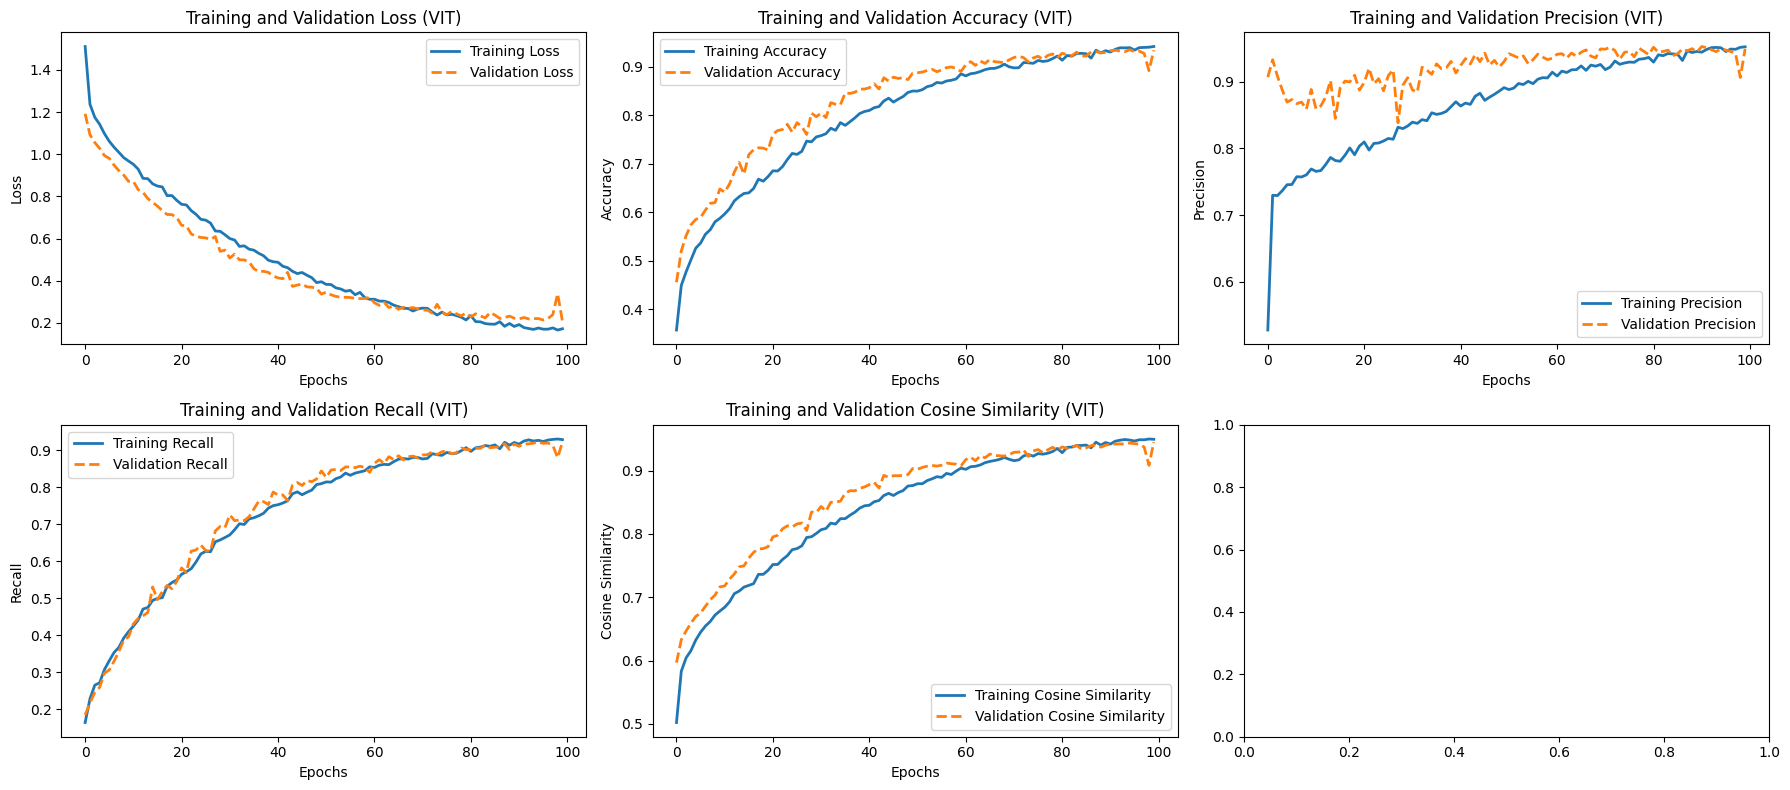

In [ ]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(vit_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(vit_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (VIT)')

# Plot training and validation accuracy
axes[0, 1].plot(vit_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(vit_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (VIT)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(vit_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(vit_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (VIT)')

axes[1, 0].plot(vit_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(vit_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (VIT)')

axes[1, 1].plot(vit_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(vit_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (VIT)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [ ]:
# Evaluate the model
evaluation_results = vit.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
vit.save(f"{path}/vit.h5")
print("Model saved to", f"{path}/vit.h5")

118/118 [==============================] - 4s 33ms/step - loss: 0.1983 - categorical_accuracy: 0.9375 - top_5_categorical_accuracy: 1.0000 - precision: 0.9545 - recall: 0.9252 - cosine_similarity: 0.9473
Evaluation results: [0.19829998910427094, 0.9374666810035706, 1.0, 0.9544704556465149, 0.9251999855041504, 0.9472753405570984]
Model saved to /content/NSCLC_Radiomics_50k_splitted2/vit.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 1s 5ms/step


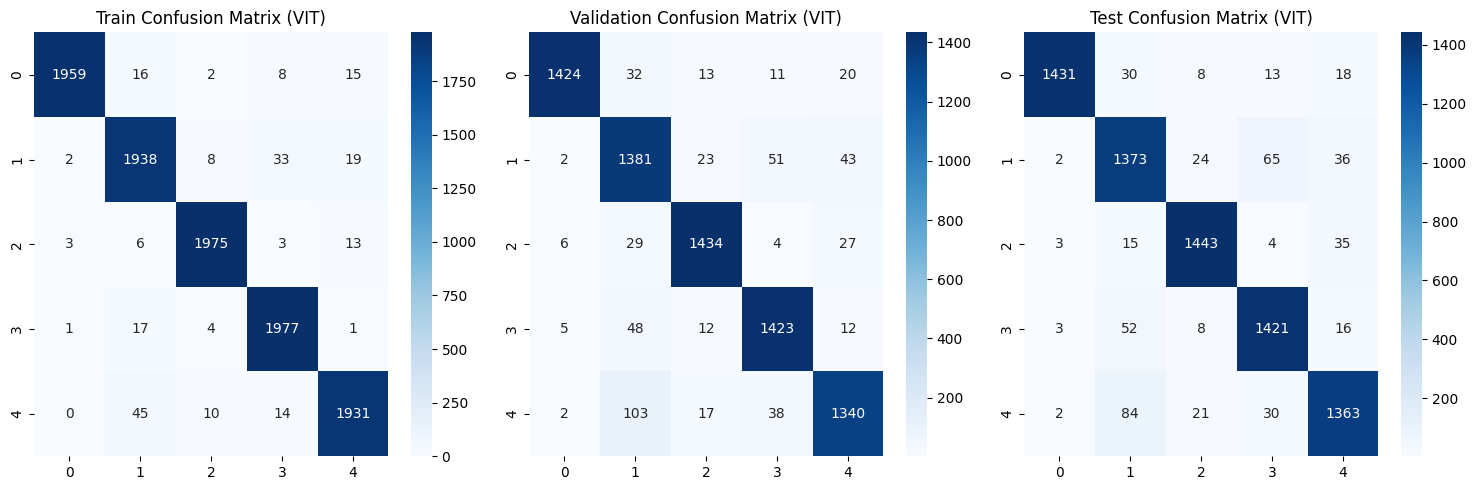

In [ ]:
# Generate predictions for train, validation, and test datasets
train_predictions = vit.predict(train_ds)
val_predictions = vit.predict(val_ds)
test_predictions = vit.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (VIT)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (VIT)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (VIT)')

plt.tight_layout()
plt.show()

In [ ]:
from keras.applications import ResNet152V2
#Creating Models (Reducing dimentions and preventing Overfitting)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(80, 80, 3))


for layer in base_model.layers:
    layer.trainable=True
resnet = Sequential()
resnet.add(base_model)
resnet.add(GaussianNoise(0.25))
resnet.add(GlobalAveragePooling2D())
resnet.add(Dense(128,activation='relu'))
resnet.add(BatchNormalization())
resnet.add(GaussianNoise(0.25))
resnet.add(Dropout(0.25))
resnet.add(Flatten())
resnet.add(Dense(5, activation='softmax'))
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 gaussian_noise_2 (Gaussian  (None, 3, 3, 2048)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                      

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_student_loss',
    patience=30,
    verbose=1,
    restore_best_weights=True
)
distiller = Distiller(student=resnet, teacher=vit)
distiller.compile(
    optimizer=tf.keras.optimizers.SGD(),
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
distiller_train1_losses = []
distiller_train2_losses = []
distiller_val_losses = []
distiller_train_accuracies = []
distiller_val_accuracies = []
distiller_train_precisions = []
distiller_val_precisions = []
distiller_train_recalls = []
distiller_val_recalls = []
distiller_train_cosine_similarity = []
distiller_val_cosine_similarity = []

for epoch in range(100):
    # Train the model for one epoch
    history = distiller.fit(train_ds, epochs=1, validation_data=val_ds, steps_per_epoch=100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    distiller_train1_losses.append(history.history['distillation_loss'][0])
    distiller_train2_losses.append(history.history['student_loss'][0])
    distiller_val_losses.append(history.history['val_student_loss'][0])
    distiller_train_accuracies.append(history.history['categorical_accuracy'][0])
    distiller_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    distiller_train_precisions.append(history.history['precision'][0])
    distiller_val_precisions.append(history.history['val_precision'][0])
    distiller_train_recalls.append(history.history['recall'][0])
    distiller_val_recalls.append(history.history['val_recall'][0])
    distiller_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    distiller_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_student_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_student_loss'][0]
        best_weights = distiller.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
distiller.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.


100/100 [==============================] - 37s 371ms/step - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000 - student_loss: 8.5068e-04 - distillation_loss: 8.4434e-04 - val_categorical_accuracy: 0.8629 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.8769 - val_recall: 0.8529 - val_cosine_similarity: 0.8780 - val_student_loss: 0.6149


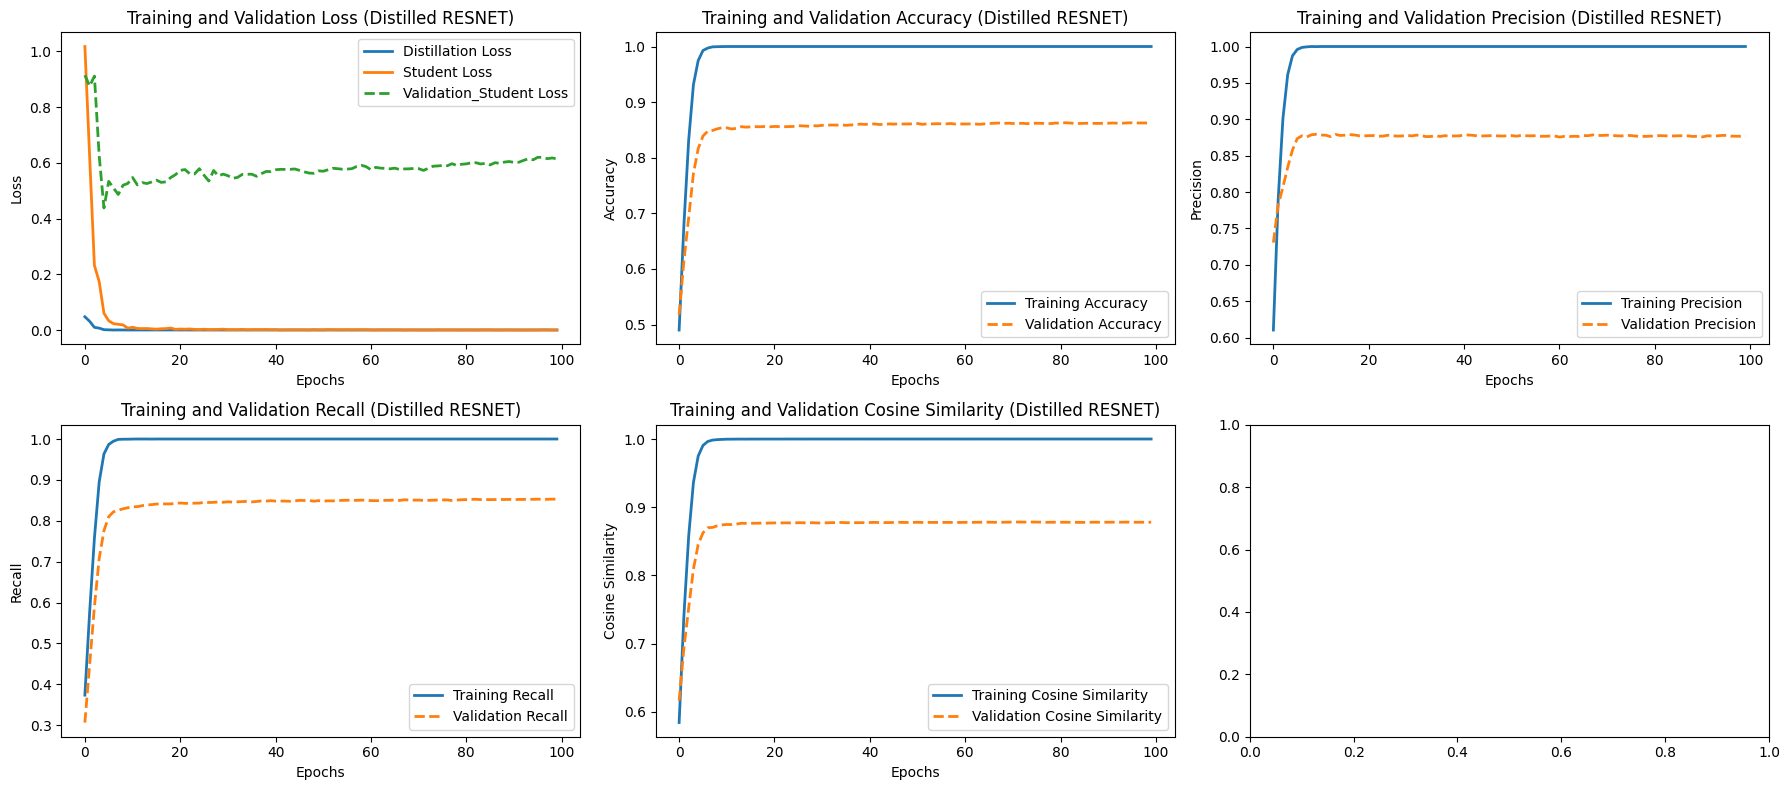

In [ ]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(distiller_train1_losses, label='Distillation Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(distiller_train2_losses, label='Student Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(distiller_val_losses, label='Validation_Student Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (Distilled RESNET)')

# Plot training and validation accuracy
axes[0, 1].plot(distiller_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(distiller_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (Distilled RESNET)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(distiller_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(distiller_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (Distilled RESNET)')

axes[1, 0].plot(distiller_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(distiller_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (Distilled RESNET)')

axes[1, 1].plot(distiller_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(distiller_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (Distilled RESNET)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [ ]:
# Evaluate the model
evaluation_results = distiller.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
#distiller.save(f"{path}/distiller.h5")
print("Model saved to", f"{path}/distiller1.h5")

118/118 [==============================] - 10s 83ms/step - categorical_accuracy: 0.8160 - top_5_categorical_accuracy: 1.0000 - precision: 0.8630 - recall: 0.7745 - cosine_similarity: 0.8457 - student_loss: 0.5182
Evaluation results: [0.8159999847412109, 1.0, 0.8630218505859375, 0.7745333313941956, 0.8456982970237732, 0.38514700531959534]
Model saved to /content/NSCLC_Radiomics_50k_splitted2/distiller1.h5


118/118 [==============================] - 9s 77ms/step


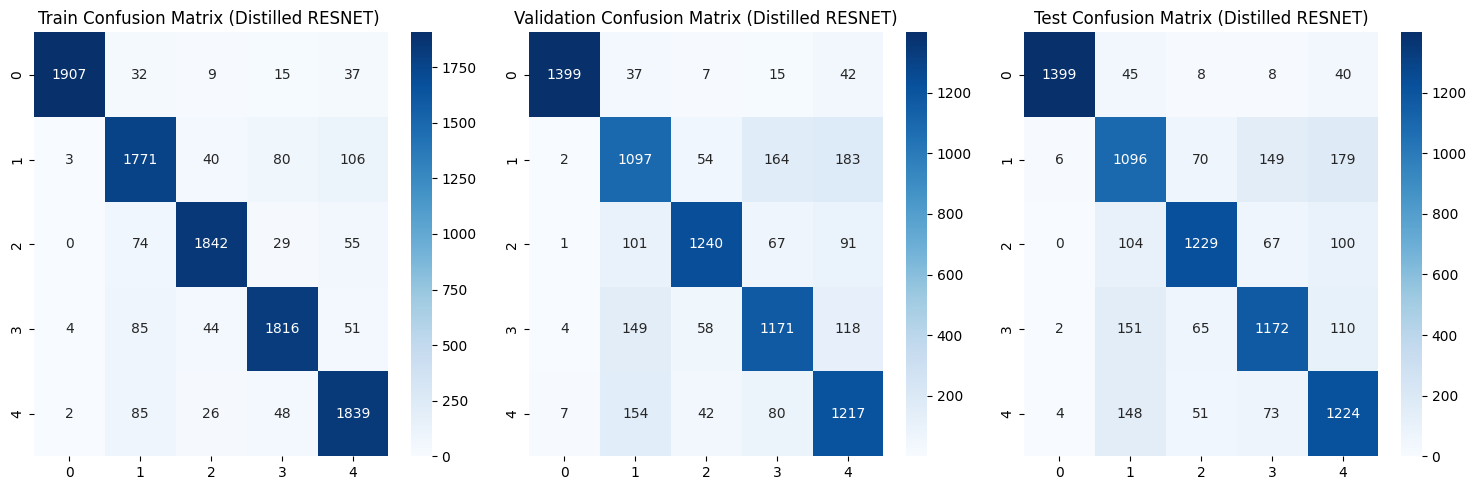

In [ ]:
# Generate predictions for train, validation, and test datasets
train_predictions = resnet.predict(train_ds)
val_predictions = resnet.predict(val_ds)
test_predictions = resnet.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (Distilled RESNET) ')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (Distilled RESNET)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (Distilled RESNET)')

plt.tight_layout()
plt.show()

In [ ]:
# Define early stopping callback for ResNet
early_stopping_resnet = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the ResNet model with additional metrics (Precision, Recall, and Cosine Similarity)
resnet.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),  # Precision
        tf.keras.metrics.Recall(name='recall'),  # Recall
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')  # Cosine Similarity
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights for ResNet
best_val_loss_resnet = float('inf')
best_weights_resnet = None

# Lists to store training and validation metrics for ResNet
resnet_train_losses = []
resnet_val_losses = []
resnet_train_accuracies = []
resnet_val_accuracies = []
resnet_train_precisions = []
resnet_val_precisions = []
resnet_train_recalls = []
resnet_val_recalls = []
resnet_train_cosine_similarity = []
resnet_val_cosine_similarity = []

for epoch in range(100):
    # Train the ResNet model for one epoch
    #history = resnet.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    history = resnet.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    resnet_train_losses.append(history.history['loss'][0])
    resnet_val_losses.append(history.history['val_loss'][0])
    resnet_train_accuracies.append(history.history['categorical_accuracy'][0])
    resnet_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    resnet_train_precisions.append(history.history['precision'][0])
    resnet_val_precisions.append(history.history['val_precision'][0])
    resnet_train_recalls.append(history.history['recall'][0])
    resnet_val_recalls.append(history.history['val_recall'][0])
    resnet_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    resnet_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far for ResNet
    if history.history['val_loss'][0] < best_val_loss_resnet:
        best_val_loss_resnet = history.history['val_loss'][0]
        best_weights_resnet = resnet.get_weights()

# After training, you can set the model weights to the best weights for ResNet
resnet.set_weights(best_weights_resnet)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists for ResNet.

100/100 [==============================] - ETA: 0s - loss: 0.4906 - categorical_accuracy: 0.8230 - top_5_categorical_accuracy: 1.0000 - precision: 0.8645 - recall: 0.7862 - cosine_similarity: 0.8526

100/100 [==============================] - ETA: 0s - loss: 0.4216 - categorical_accuracy: 0.8508 - top_5_categorical_accuracy: 1.0000 - precision: 0.8810 - recall: 0.8164 - cosine_similarity: 0.8738

100/100 [==============================] - ETA: 0s - loss: 0.1417 - categorical_accuracy: 0.9575 - top_5_categorical_accuracy: 1.0000 - precision: 0.9671 - recall: 0.9459 - cosine_similarity: 0.9621

100/100 [==============================] - ETA: 0s - loss: 0.0475 - categorical_accuracy: 0.9892 - top_5_categorical_accuracy: 1.0000 - precision: 0.9917 - recall: 0.9862 - cosine_similarity: 0.9900

100/100 [==============================] - ETA: 0s - loss: 0.0157 - categorical_accuracy: 0.9984 - top_5_categorical_accuracy: 1.0000 - precision: 0.9986 - recall: 0.9975 - cosine_similarity: 0.9981

100/100 [==============================] - ETA: 0s - loss: 0.0072 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 0.9997

100/100 [==============================] - ETA: 0s - loss: 0.0046 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 0.9999

100/100 [==============================] - ETA: 0s - loss: 0.0035 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 0.9999

100/100 [==============================] - ETA: 0s - loss: 0.0027 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0022 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0020 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0019 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0017 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0016 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0014 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0013 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0012 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0011 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0011 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 0.0010 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 9.9361e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 8.8710e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 8.5236e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 8.4099e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 7.9903e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 8.1194e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 8.1319e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 7.1727e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 6.7923e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 6.9090e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 6.5069e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 6.2948e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 5.8390e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 5.8900e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 5.6661e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 5.9037e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 5.3985e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 5.4376e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 5.4857e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.9982e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.8926e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.9255e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.8441e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.7615e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.6356e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.4623e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.4824e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.4396e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.1618e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.1986e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.1355e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 4.1260e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.6356e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.9432e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.7453e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.8554e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.4892e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.4638e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.7321e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.6431e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.4877e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.2851e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.3463e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.5129e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.2255e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.0754e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.1160e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.1015e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.0863e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.0151e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.1359e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.9277e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 3.2128e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.9180e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.8577e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.9174e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.7520e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.6682e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.5401e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.7768e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.7160e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.6708e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.6364e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.5452e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.4819e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.5827e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.3501e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.5419e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.3737e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.2952e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.4512e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.4029e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.2711e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.3224e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.1648e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.2904e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.3594e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.1694e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.3158e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - ETA: 0s - loss: 2.1338e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000

100/100 [==============================] - 36s 361ms/step - loss: 2.1338e-04 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.3445 - val_categorical_accuracy: 0.9180 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.9228 - val_recall: 0.9145 - val_cosine_similarity: 0.9263


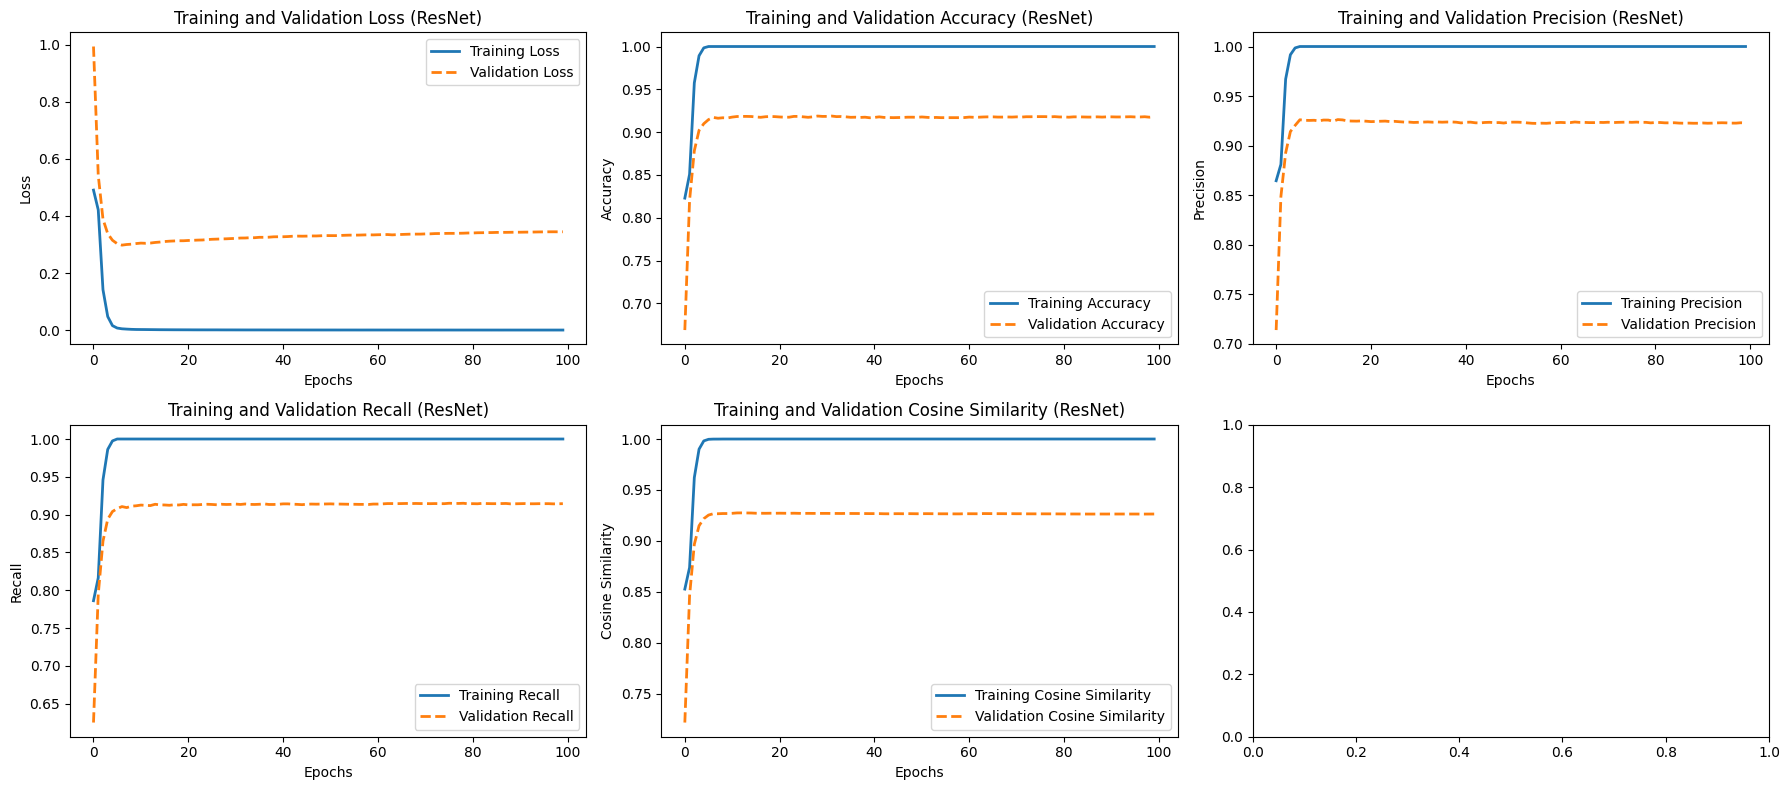

In [ ]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(resnet_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(resnet_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (ResNet)')

# Plot training and validation accuracy
axes[0, 1].plot(resnet_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(resnet_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (ResNet)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(resnet_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(resnet_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (ResNet)')

axes[1, 0].plot(resnet_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(resnet_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (ResNet)')

axes[1, 1].plot(resnet_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(resnet_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (ResNet)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [ ]:
# Evaluate the model
evaluation_results = resnet.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
resnet.save(f"{path}/resnet.h5")
print("Model saved to", f"{path}/resnet.h5")

118/118 [==============================] - 10s 83ms/step - loss: 0.2917 - categorical_accuracy: 0.9159 - top_5_categorical_accuracy: 1.0000 - precision: 0.9257 - recall: 0.9088 - cosine_similarity: 0.9260
Evaluation results: [0.2916575074195862, 0.9158666729927063, 1.0, 0.92570960521698, 0.9088000059127808, 0.9259636998176575]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/NSCLC_Radiomics_50k_splitted2/resnet.h5


118/118 [==============================] - 9s 81ms/step


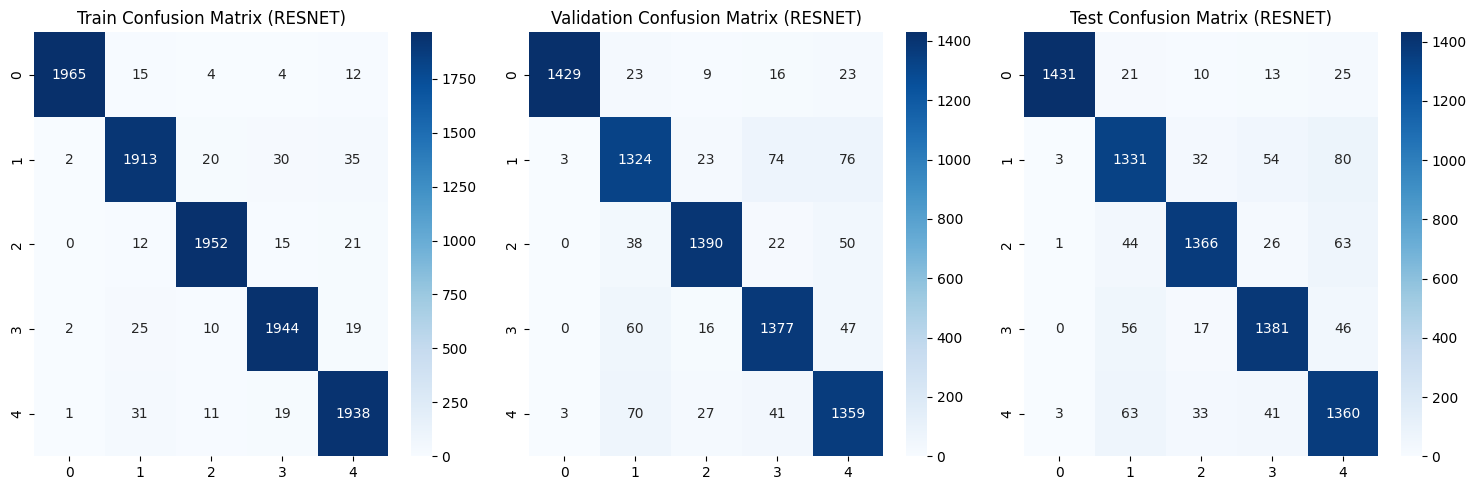

In [ ]:
# Generate predictions for train, validation, and test datasets
train_predictions = resnet.predict(train_ds)
val_predictions = resnet.predict(val_ds)
test_predictions = resnet.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (RESNET)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (RESNET)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (RESNET)')

plt.tight_layout()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Create a simple CNN model
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(80, 80, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(5, activation='softmax'))

# Display the model summary
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 39, 39, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 97344)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               24920320  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                      

In [38]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_student_loss',
    patience=30,
    verbose=1,
    restore_best_weights=True
)
distiller = Distiller(student=cnn, teacher=resnet)
distiller.compile(
    optimizer=tf.keras.optimizers.SGD(),
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
distiller_train1_losses = []
distiller_train2_losses = []
distiller_val_losses = []
distiller_train_accuracies = []
distiller_val_accuracies = []
distiller_train_precisions = []
distiller_val_precisions = []
distiller_train_recalls = []
distiller_val_recalls = []
distiller_train_cosine_similarity = []
distiller_val_cosine_similarity = []

for epoch in range(100):
    # Train the model for one epoch
    history = distiller.fit(train_ds, epochs=1, validation_data=val_ds, steps_per_epoch=100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    distiller_train1_losses.append(history.history['distillation_loss'][0])
    distiller_train2_losses.append(history.history['student_loss'][0])
    distiller_val_losses.append(history.history['val_student_loss'][0])
    distiller_train_accuracies.append(history.history['categorical_accuracy'][0])
    distiller_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    distiller_train_precisions.append(history.history['precision'][0])
    distiller_val_precisions.append(history.history['val_precision'][0])
    distiller_train_recalls.append(history.history['recall'][0])
    distiller_val_recalls.append(history.history['val_recall'][0])
    distiller_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    distiller_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_student_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_student_loss'][0]
        best_weights = distiller.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
distiller.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.


100/100 [==============================] - 11s 112ms/step - categorical_accuracy: 0.9778 - top_5_categorical_accuracy: 1.0000 - precision: 0.9838 - recall: 0.9694 - cosine_similarity: 0.9797 - student_loss: 0.0842 - distillation_loss: 0.0038 - val_categorical_accuracy: 0.9252 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.9356 - val_recall: 0.9165 - val_cosine_similarity: 0.9351 - val_student_loss: 0.2747


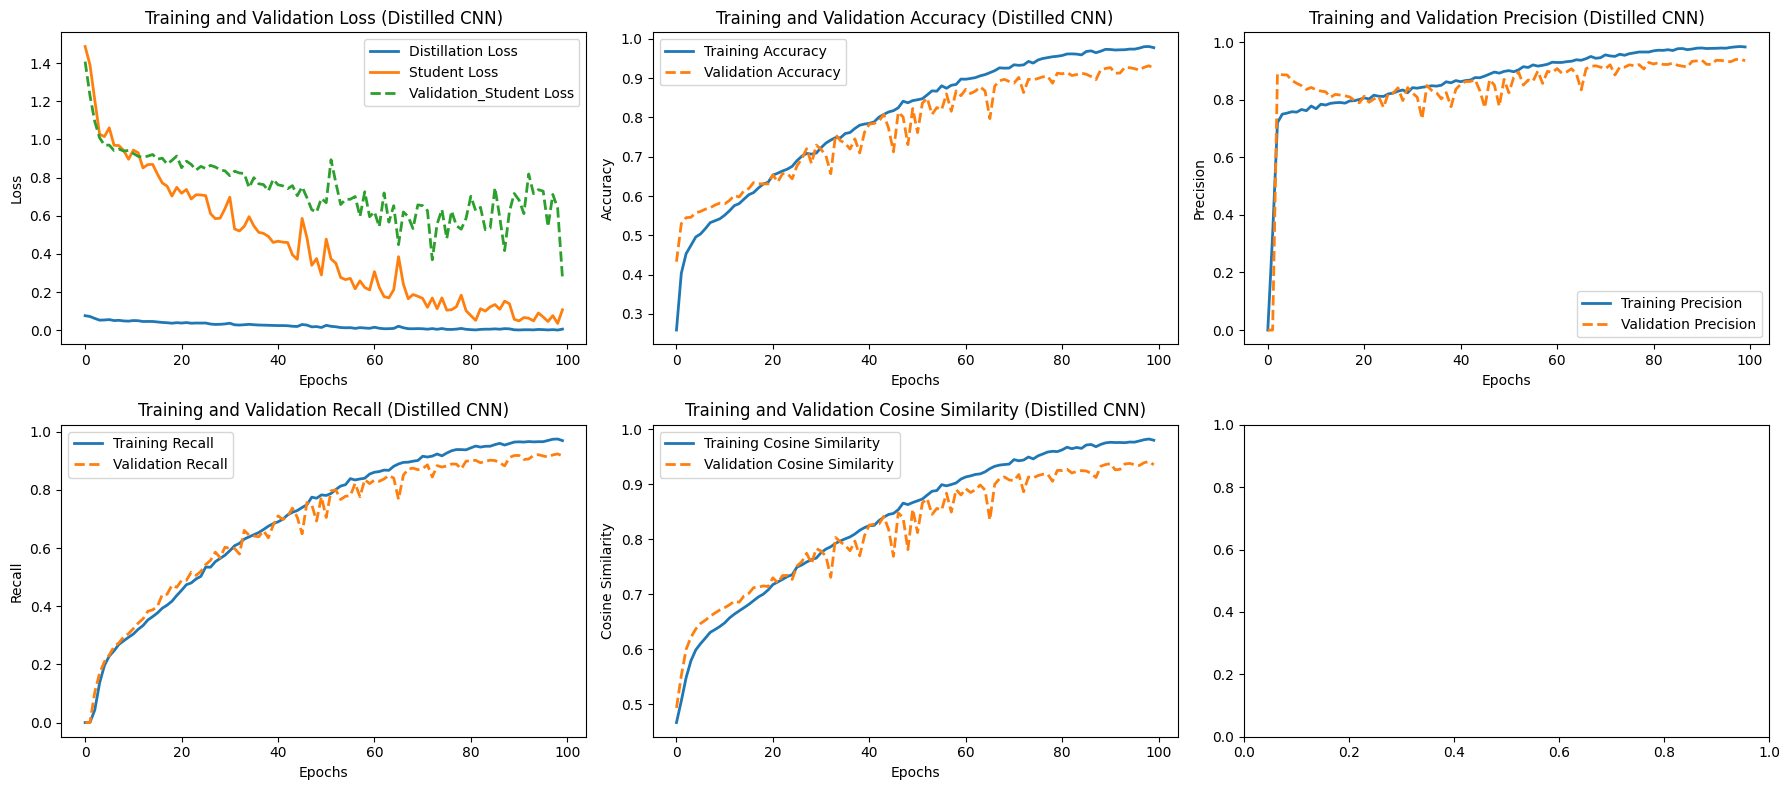

In [39]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(distiller_train1_losses, label='Distillation Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(distiller_train2_losses, label='Student Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(distiller_val_losses, label='Validation_Student Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (Distilled CNN)')

# Plot training and validation accuracy
axes[0, 1].plot(distiller_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(distiller_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (Distilled CNN)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(distiller_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(distiller_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (Distilled CNN)')

axes[1, 0].plot(distiller_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(distiller_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (Distilled CNN)')

axes[1, 1].plot(distiller_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(distiller_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (Distilled CNN)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [40]:
# Evaluate the model
evaluation_results = distiller.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
#distiller.save(f"{path}/distiller.h5")
print("Model saved to", f"{path}/distiller2.h5")

118/118 [==============================] - 1s 8ms/step - categorical_accuracy: 0.9339 - top_5_categorical_accuracy: 1.0000 - precision: 0.9433 - recall: 0.9249 - cosine_similarity: 0.9418 - student_loss: 0.2199
Evaluation results: [0.9338666796684265, 1.0, 0.9432961940765381, 0.9249333143234253, 0.9418383836746216, 0.13555435836315155]
Model saved to /content/NSCLC_Radiomics_50k_splitted2/distiller2.h5


118/118 [==============================] - 0s 3ms/step


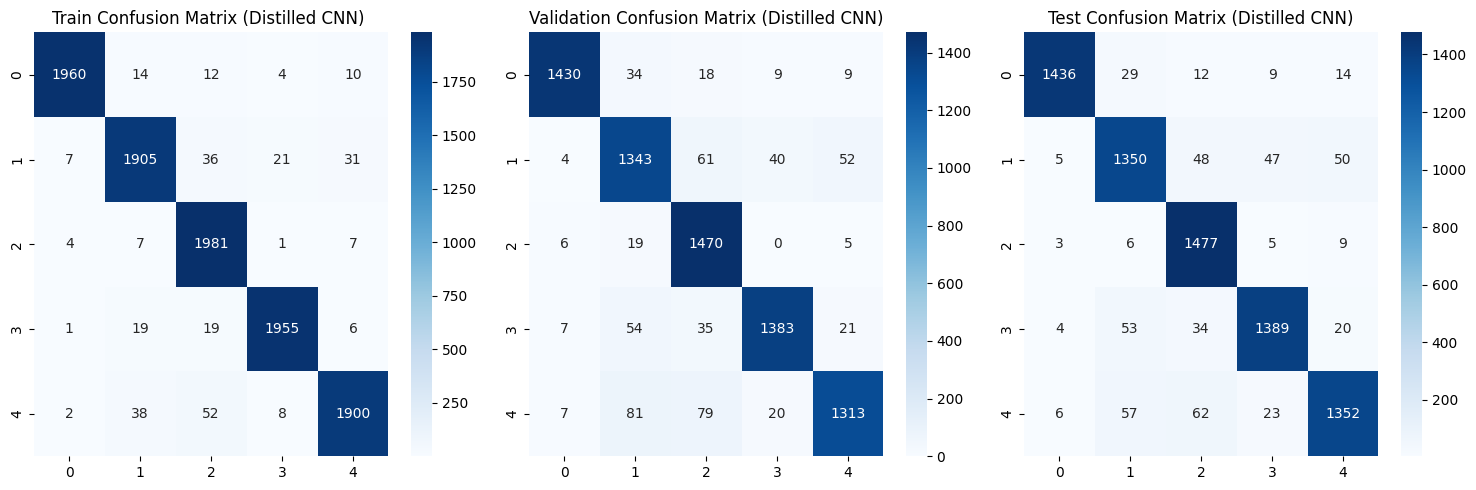

In [41]:
# Generate predictions for train, validation, and test datasets
train_predictions = cnn.predict(train_ds)
val_predictions = cnn.predict(val_ds)
test_predictions = cnn.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (Distilled CNN) ')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (Distilled CNN)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (Distilled CNN)')

plt.tight_layout()
plt.show()